This notebook will be my attempt at experimenting with the Google Colaboratory environment.

In [1]:
!pip show tensorflow

# Install relevant packages
!pip install -q gym
!pip -q install pyglet

import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt

# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

Name: tensorflow
Version: 1.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, wheel, tensorboard, keras-preprocessing, keras-applications, grpcio, tensorflow-estimator, six, protobuf, astor, termcolor, absl-py, gast
Required-by: stable-baselines, magenta, fancyimpute
[[22. 28.]
 [49. 64.]]


In this notebook, I will be experimenting with the [Cartpole](https://gym.openai.com/envs/CartPole-v0/) environment in OpenAI's gym. I will also be trying to answer some of the questions from one of OpenAi's request for research, [Cartpole: for newcomers to RL](https://openai.com/requests-for-research/#cartpole). The metrics used for comparing the different attempts at solving this environment is also referenced from this [blog post](http://kvfrans.com/simple-algoritms-for-solving-cartpole/)

Below this cell are some information on OpenAI's CartPole environment.

In [2]:
env = gym.make('CartPole-v0')

print("Some information about this environment:")
print('Observation space:', env.observation_space)
print('Maximum of Observation space:', env.observation_space.high)
print('Minimum of Observation space:', env.observation_space.low)
print('Sample of Observation space:', env.observation_space.sample())
print('Action space:', env.action_space)
print('Sample of Action space:', env.action_space.sample())

obs = env.reset()
print('Initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('Next observation:', obs)
print('Reward:', r)
print('Done:', done)
print('Info:', info)

Some information about this environment:
Observation space: Box(4,)
Maximum of Observation space: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Minimum of Observation space: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Sample of Observation space: [4.6860966e-01 1.4645028e+38 8.6090848e-02 3.0545910e+37]
Action space: Discrete(2)
Sample of Action space: 1
Initial observation: [ 0.03857269 -0.01707286 -0.04233381  0.02914776]
Next observation: [ 0.03823123  0.17862981 -0.04175085 -0.27658567]
Reward: 1.0
Done: False
Info: {}


In [0]:
# Define a function to run an episode of Cartpole's environment
def run_episode(env, model_params):
  # Start new episode
  obs = env.reset()
  done = False
  total_r = 0
  total_step = 0
  
  state_list = []
  action_list = []
  r_list = []
  
  # Step through episode
  while not done:
    pred = model_params * obs
    if np.sum(pred) >= 0:
      action = 1
    else:
      action = 0
      
    state_list.append(obs)
    action_list.append(action)
    obs, r, done, info = env.step(action)
    r_list.append(r)
    total_step += 1
    total_r += r
  
  return total_r, total_step, state_list, action_list, r_list

As mentioned in the request, the first algorithm that I experimented with was a random guessing algorithm. I basically randomly generate model parameters from the uniform distribution until the Cartpole environment is solved (the Cartpole is kept up for 200 timesteps). I then repeat this for 1000 times to see how many guesses on average the random guessing algorithm needs to solve the Cartpole environment.

The policy used here will be a simple linear model:

$a = \begin{cases}
  \hfill 0 \hfill & \text{ if $\theta s$ < 0} \\
  \hfill 1 \hfill & \text{ else}
\end{cases}$

where $\theta$ are the model parameters and $s$ are the observations gotten from the environment.

Here are the results from the random guessing algorithm on a simple linear model:

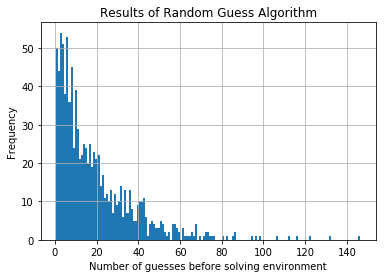

In [4]:
tries_list = []

# Try out 10000 random configurations of model parameters
for idx in range(1000):
  num_tries = 0
  best_r = 0
  
  while best_r < 200:
    # Generate model parameters
    cur_model_params = np.random.uniform(size=(4,1))
  
    # Run episode
    best_r, _, _, _, _ = run_episode(env, cur_model_params)
    
    # Record down number of guesses needed
    num_tries += 1
    
  tries_list.append(num_tries)

# Plot out the results of the runs
n, bins, patches = plt.hist(tries_list, bins=max(tries_list), align='left')
plt.xlabel('Number of guesses before solving environment')
plt.ylabel('Frequency')
plt.title('Results of Random Guess Algorithm')
plt.grid(True)
plt.show()

The second algorithm that I experimented with was a hill climbing algorithm. I basically randomly sample initial model parameters from the uniform distribution and then slow perturb the parameters with some random small values until the model parameters are able to return cummulative reward of 200 or exceed 500 iterations in the Cartpole environment. This is repeated for 1000 times to see how many iterations the hill climbing algorithms needs to solve the Cartpole environment.

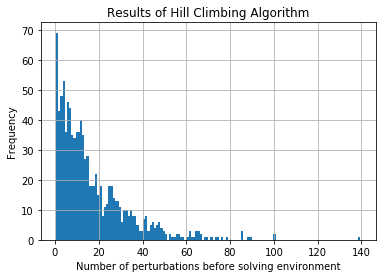

In [5]:
epsilon = 1e-6
tries_list = []

# Try out 1000 hill climbing algorithm iterations
for idx in range(1000):
  cur_model_params = np.random.uniform(size=(4,1))
  cur_total_reward = 0
  num_iterations = 0
  
  # Runs hill-climbing algorithm until reached best reward possible
  while cur_total_reward < 200 and num_iterations < 500:
    perturbation = np.random.uniform(size=(4,1)) * epsilon
    new_model_params = cur_model_params + perturbation
    num_iterations += 1

    # Run episode
    total_r, total_step, _, _, _ = run_episode(env, cur_model_params)

    # Record the parameters of the model with highest cummulative rewards
    if total_r > cur_total_reward:
      cur_model_params = new_model_params
      cur_total_reward = total_r
      
  tries_list.append(num_iterations)
    
# Plot out the results of the runs
n, bins, patches = plt.hist(tries_list, bins=max(tries_list), align='left')
plt.xlabel('Number of perturbations before solving environment')
plt.ylabel('Frequency')
plt.title('Results of Hill Climbing Algorithm')
plt.grid(True)
plt.show()

The last algorithm that I experimented with is the policy gradient algorithm.

Generally, policy gradient methods aim to iteratively improve the performance of a policy that is differentiable with respect to its parameters, that is, $\nabla_\theta \pi(a | s, \theta)$ exists. In this implementation of policy gradient, the policy is parameterized simply as:

$\pi(a_i | s, \theta) = \frac{exp(\theta_i^\top s)}{\sum_{i=0}^{n}{exp(\theta_i^\top s)}}$

In the code below, the episodic variant of the Monte Carlo Policy-Gradient Method is used. Details of the exact implementation can be found in the textbook, Reinforcement Learning: An Introduction 2nd Ed. by Sutton and Barto. Essentially, we first use the existing model parameters to generate a series of observations, actions and rewards. At the end of the episode, we collect those values and update the model parameters $T$ times, where $T$ is the total number of timesteps generated from the episode. The update rule used is:

$\theta \leftarrow \theta + \alpha \gamma^t G \nabla_\theta ln \pi(a_t | s_t, \theta)$ where $G$ is the return from step $t$

Instructions for updating:
Colocations handled automatically by placer.


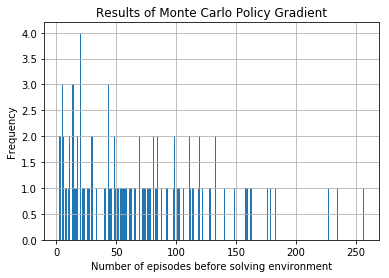

In [6]:
def run_episode_tensorflow(sess, env, action_prob):
  # Start new episode
  obs = env.reset()
  done = False
  
  state_list = []
  action_list = []
  r_list = []
  
  # Step through episode
  while not done:
    cur_action_prob = sess.run(action_prob, feed_dict={observation_placeholder: obs.reshape(1, 4)})
    action = np.random.binomial(1, cur_action_prob[0][1], 1)[0]
      
    state_list.append(obs)
    action_list.append(action)
    obs, r, done, info = env.step(action)
    r_list.append(r)
  
  return state_list, action_list, r_list

# Use softmax to give each action a probability
epsilon = tf.constant(0.05, dtype=tf.float32)
observation_placeholder = tf.placeholder(dtype=tf.float32, shape=(None, 4))
action_placeholder = tf.placeholder(dtype=tf.int32, shape=())
v = tf.placeholder(dtype=tf.float32, shape=())
model_params = tf.Variable(tf.random_uniform(shape=(4, 2), minval=0, maxval=1.0, dtype=tf.float32))
preds = tf.matmul(observation_placeholder, model_params)
action_prob = tf.nn.softmax(preds)
action_grad = tf.gradients(tf.log(action_prob[:, action_placeholder]), model_params)
update_step = model_params.assign(model_params + epsilon * tf.squeeze(action_grad) * v)

# Use Monte Carlo Policy Gradient
tries_list = []

for episode in range(100):
  num_tries = 0
  cur_r = 0
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    while cur_r < 200:
      state_list, action_list, r_list = run_episode_tensorflow(sess, env, action_prob)
      cur_r = sum(r_list)
      num_tries += 1
    
      # Policy gradient update step
      for idx, (state, action) in enumerate(zip(state_list, action_list)):
        _ = sess.run(update_step, feed_dict={observation_placeholder: state.reshape(1, 4), action_placeholder: action, v:sum(r_list[idx:])})
        
    tries_list.append(num_tries)

# Plot out the results of the runs
n, bins, patches = plt.hist(tries_list, bins=max(tries_list), align='left')
plt.xlabel('Number of episodes before solving environment')
plt.ylabel('Frequency')
plt.title('Results of Monte Carlo Policy Gradient')
plt.grid(True)
plt.show()    

Comparing the 3 methods for the Cartpole environment, I would say that the Random Guess algorithm performs pretty similarly to the Hill Climbing algorithm. However, the Polciy Gradient algorithm is performing much worse as compared to the other two algorithms.

It is likely because of the small observation space and action space (resulting in a low dimensional linear model) that the Random Guess algorithm works at all. If this algorithm was used to find solutions in an extremely high dimensional space, it would probably be no where near as successful. Since the hill climbing is based on random perturbations, I would think that each iterative update the algorithm does is heavily dependent on the initial guess and depending on the learning rate of the algorithm, each update could be as good as a new random guess for the model parameters.

As for the policy gradient, while each update iteration is more directed than the hill climbing algorithm, it does not seem to perform as well for the Cartpole environment. I believe that we will be able to see the benefits of the policy gradient algorithm once we employ it on environments with observations and actions of much higher dimensions. The fact that each iteration ensures that the model parameters are converging towards some sort of objective ($\nabla_\theta J \propto E_\pi[\sum_{a}^{}q_\pi(S_t, a) \nabla_\theta\pi(a | S_t, \theta)]$) implies that this algorithm would probably fare better than the other two in higher dimensional environments.